In [1]:
# Imports
import numpy as np
import math
import matplotlib.pyplot as plt
from __future__ import division
np.random.seed(1)

### Q.1 (70pts) Define functions

In [2]:
# One hot encode the labels
def one_hot_encode(y):
    targets = np.array(np.unique(y)).reshape(-1)
    enc = np.eye(len(targets))[y]
    print(enc)
    return enc

# Get the loss of for the training example
def cross_entropy(Y, Yhat):
    m= Y.shape[1]
    loss = np.multiply(np.log(Yhat),Y) + np.multiply((1.-Y), np.log(1. - Yhat))
    loss = np.sum(loss)
    cost = -1./m * np.sum(loss)
    cost = np.squeeze(cost)
    return cost

# Applying Sigmoid Activation function to the hidden layer outputs used while forward propagation
# Purpose of this method is to do squishing on the linear function
def sigmoid(z):
    return 1./(1+np.exp(-z))

# Applying Sigmoid Activation function to the hidden layer outputs used while backward propagation to get gradients
# Purpose of this method is to do undo the squishing on the linear function
def sigmoid_prime(z):
    inv = (np.exp(-z))/(np.power((1+np.exp(-z)),2))
    return inv

def relu(z):
    return np.maximum(z,0)
    
def relu_prime(z):
    return np.where(z < 0, 0.0, 1.0)

# Softmax activation function to get the probablity of the classes
def softmax(z):
    softMax = (np.exp(z) / np.sum(np.exp(z),axis=0))
    softMax = np.matrix(np.argmax(softMax,axis=0)).T
    return softMax

def zero_pad(X, pad):
    ## Pads the height and width and breadth only by 'pad' columns using constant value, 4 dimensional padding
    padded_array = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0,0)), 'constant', constant_values = (0,0))
    print("Dimension after padding" + str(padded_array.shape))
    return padded_array

# Convolution of a slice
def convolute_slice(a_slice, W, b):
    conv = np.multiply(a_slice, W)
    z = np.sum(conv) + float(b)
    return z

# Calculate the coordinates of the slice
def get_slice_coordinates(stride, f, w, h):
    vert_start = h * stride
    vert_end = vert_start + f
    horiz_start = w * stride
    horiz_end = horiz_start + f
    return vert_start, vert_end, horiz_start, horiz_end

# Flatten the array
def flatten(A):
    (m, nH, nW, nC) = A.shape
    print('Shape before flattening is----')
    print(A.shape)
    A = A.reshape(m, nH * nW * nC)
    print('Shape after flattening is----')
    print(A.shape)
    return A.transpose()

def convolute_forward(A_prev, W, b, hyper_params):
    # Get the required parameters
    m, nH_prev, nW_prev, nC_prev = A_prev.shape
    f, f, nC_prev, nC  = W.shape
    pad = hyper_params["pad"]
    stride = hyper_params["stride"]
    print('convolution nH_prev, f, pad, stride---------------')
    print(nH_prev, f, pad, stride)
    # Calculate the dimensions of input
    nH = int((nH_prev -f + 2 * pad)/stride) + 1
    nW = int((nW_prev -f + 2 * pad)/stride) + 1
    print('convolution m, nH, nW, nC---------------')
    print(m, nH, nW, nC)
    # Calculate the dimensions of output
    Z = np.zeros((m, nH, nW, nC))
    A_prev_pad = zero_pad(A_prev, pad)
    
    # referring professor's code for forward propagation
    for i in range(m):
        a_pad_prev = A_prev_pad[i, :, :, :]
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):
                    # Find the coordinates of the current slice
                    vert_start, vert_end, horiz_start, horiz_end = get_slice_coordinates(stride, f, w, h)
                    
                    # Extract the slice from input
                    a_slice_prev = a_pad_prev[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron
                    Z[i, h, w, c] = convolute_slice(a_slice_prev, W[:, :, :, c], b[:, :, :, c])
                    
    cache = (A_prev, W, b, hyper_params)
    return Z

def pool_forward(A_prev, hyper_params, pooling_method):
    # Get the required parameters
    (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
    print('Pooling (m, nH_prev, nW_prev, nC_prev---------------')
    print(m, nH_prev, nW_prev, nC_prev)
    f = hyper_params["f"]
    stride = hyper_params["stride"]
    print('Pooling f, stride')
    print(f, stride)
    # Calculate the dimensions of the output
    nH = int(1 + (nH_prev - f) / stride)
    nW = int(1 + (nW_prev - f) / stride)
    nC = nC_prev
    #print(nH, nW, nC)
    # Initialize the output matrix
    A = np.zeros((m, nH, nW, nC))
    
    for i in range(m):
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):
                    
                    # Find the coordinates of the current slice
                    vert_start, vert_end, horiz_start, horiz_end = get_slice_coordinates(stride, f, w, h)
                    
                     # Extract the slice from input
                    a_slice_prev = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Perform the pooling on the slice
                    if(pooling_method == "max"):
                        A[i, h, w, c] = np.max(a_slice_prev)
                    elif(pooling_method == "avg"):
                        A[i, h, w, c] = np.mean(a_slice_prev)
    cache = (A_prev, hyper_params)                
    assert(A.shape == (m, nH, nW, nC))
    return A
        
             
def convolute_backward(dZ, cache):
    (A_prev, W, b, hyper_params) = cache
    # Get the input dimensions
    (m, nH_prev, nW_prev, nC_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    stride = hyper_params["stride"]
    pad = hyper_params["pad"]
    (m, nH, nW, nC) = dZ.shape
    dA_prev = np.zeros((m, nH_prev, nW_prev, nC_prev))                           
    dW = np.zeros((f, f, nC_prev, nC))
    db = np.zeros((1, 1, 1, n_C))
    A_pad_prev = zero_pad(A_prev, pad)
    dA_pad_prev = zero_pad(dA_prev, pad)
    
    for i in range(m):
        
        a_pad_prev = A_pad_prev[i,:,:,:]
        da_pad_prev = dA_pad_prev[i,:,:,:]
        
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):

                    # Find the coordinates of the current slice
                    vert_start, vert_end, horiz_start, horiz_end = get_slice_coordinates(stride, f, w, h)

                    # Extract the slice from input
                    a_slice = A_pad_prev[i, vert_start:vert_end, horiz_start:horiz_end, :]

                    da_pad_prev[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
    
        dA_prev[i, :, :, :] = da_pad_prev[pad:-pad, pad:-pad, :]
    assert(dA_prev.shape == (m, nH_prev, nW_prev, nC_prev))
    return dA_prev, dW, db


# Backward pass for max pooling for a slice
def backprop_max_pooling(x):
    mask = x==np.max(x)
    return mask

# Backward pass for avg pooling for a slice
def backprop_avg_pooling(dz, slice_shape):
    (nH, nW) = slice_shape
    avg = dz/(nH * nW) # calculate avg
    a = np.ones((nH, nW)) * avg
    return a


def pool_backward(dA, cache, pooling_method):
    (A_prev, hyper_params) = cache
    stride = hparameters["stride"]
    f = hparameters["f"]
    m, nH_prev, nW_prev, nC_prev = A_prev.shape
    m, nH, nW, nC = dA.shape
    dA_prev = np.zeros((m, nH_prev, nW_prev, nC_prev))
    
    for i in range(m):
        a_prev = A_prev[i,:,:,:]
        for h in range(nH):
            for w in range(nW):
                for c in range(nC):
                    
                    # Find the coordinates of the current slice
                    vert_start, vert_end, horiz_start, horiz_end = get_slice_coordinates(stride, f, w, h)
                    
                    if(pooling_method == "max"):
                        a_slice_prev = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]                  
                        mask = backprop_max_pooling(a_slice_prev)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += mask * dA[i, h, w, c]

                    elif(pooling_method == "avg"):
                        da = dA[i, h, w, c]
                        shape = (f,f)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += backprop_avg_pooling(da, shape)
    
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev


# Forward propagation to calculate yHat by applying activation function twice
def forward_propagate(cache, hyper_params, parameters):
    
    # Layer 1 Convolution
    cache["Z1c"] = convolute_forward(cache["A0"], parameters["W1c"], parameters["b1c"], hyper_params["c1"]) # Convolution
    cache["A1c"] = relu(cache["Z1c"]) # Relu Activation
    
    # Layer 1 Pooling 
    cache["A1p"] = pool_forward(cache["A1c"], hyper_params["p1"], pooling_method="max") # Pooling
    
    # Layer 2 Convolution 
    cache["Z2c"] = convolute_forward(cache["A1p"], parameters["W2c"], parameters["b2c"], hyper_params["c2"]) # Convolution
    cache["A2c"] = relu(cache["Z2c"]) # Relu Activation
    
    # Layer 2 Pooling 
    cache["A2p"] = pool_forward(cache["A2c"],hyper_params["p2"], pooling_method="avg") # Pooling
    
    # Flatten the array
    #cache["A3"] = cache["A2p"].flatten()
    print("cache[A2p] ---- shape")
    print(cache["A2p"].shape)
    cache["A3"] = flatten(cache["A2p"])
    print("cache[A3] ---- shape")
    print(cache["A3"].shape)
    # Fully Connected Layer 4
    cache["Z4"] = np.dot(parameters["W4"], cache["A3"]) + parameters["b4"]
    cache["A4"] = relu(cache["Z4"]) # Relu Activation 
    
    # Fully Connected Layer 5
    cache["Z5"] = np.dot(parameters["W5"], cache["A4"]) + parameters["b5"]
    cache["A5"] = sigmoid(cache["Z5"]) # Sigmoid Activation 

    return cache

### Q.2 Load data

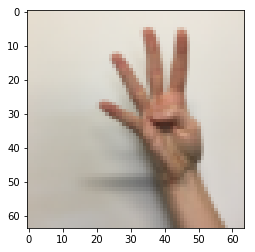

Digit in the image is 4
(1020, 64, 64, 3)


In [3]:
X_train = np.load('ex5_train_x.npy')
y_train = np.load('ex5_train_y.npy')
indx = 2
plt.imshow(X_train[indx])
plt.show()
print("Digit in the image is " + str(y_train[indx]))
print(X_train.shape)

# Normalize the data
X_train_norm = X_train/255

# y_train_encoded = one_hot_encode(y_train)
# X_train_padded = zero_pad(X_train, 2)

### Q.3 (10pts) Initialize parameters (Weights, bias for each layer)

In [4]:
def initialize_parameters(input_channl, conv1_f, channl_1, conv2_f, channl_2, 
                          input_size, fc1_size, fc2_size):
    params = {}
    # Convolution Layer 1 Params
    params["W1c"] =  np.random.randn(conv1_f, conv1_f, input_channl, channl_1)
    params["b1c"] =  np.zeros((1,1,1, channl_1))
    
    # Convolution Layer 2 Params
    params["W2c"] =  np.random.randn(conv2_f, conv2_f, channl_1, channl_2)
    params["b2c"] =  np.zeros((1,1,1,channl_2))
    
    # FC layer 4 params
    params["W4"] =  np.random.randn(fc1_size, input_size)
    params["b4"] =  np.zeros((fc1_size, 1))
    
    # FC layer 5 params
    params["W5"] =  np.random.randn(fc2_size, fc1_size)
    params["b5"] =  np.zeros((fc2_size, 1))
    
    return params

### Initialize Hyper Parameters

In [5]:
def initialize_hyper_params():
    
    hyper_params = {}
    
    # Convolution Layer 1 Hyper Parameters
    hyper_params_c1 = {}
    hyper_params_c1["stride"] = 2
    hyper_params_c1["pad"] = 1
    
    # Pooling Layer 1 Hyper Parameters
    hyper_params_p1 = {}
    hyper_params_p1["stride"] = 1
    hyper_params_p1["pad"] = 0
    hyper_params_p1["f"] = 5
    
    # Convolution Layer 2 Hyper Parameters
    hyper_params_c2 = {}
    hyper_params_c2["stride"] = 2
    hyper_params_c2["pad"] = 0
    
    # Pooling Layer 2 Hyper Parameters
    hyper_params_p2 = {}
    hyper_params_p2["stride"] = 1
    hyper_params_p2["pad"] = 0
    hyper_params_p2["f"] = 5
    
    hyper_params["c1"] = hyper_params_c1
    hyper_params["p1"] = hyper_params_p1
    
    hyper_params["c2"] = hyper_params_c2
    hyper_params["p2"] = hyper_params_p2
    
    return hyper_params
    

In [6]:
cache = {}
cache["A0"] = X_train_norm
params = initialize_parameters(input_channl=3, conv1_f=4, channl_1=8, conv2_f=4, channl_2=16, 
                          input_size=1296, fc1_size=108, fc2_size=6)
hyper_params = initialize_hyper_params()
cache = forward_propagate(cache, hyper_params, params)

convolution nH_prev, f, pad, stride---------------
(64, 4, 1, 2)
convolution m, nH, nW, nC---------------
(1020, 32, 32, 8)
Dimension after padding(1020, 66, 66, 3)
Pooling (m, nH_prev, nW_prev, nC_prev---------------
(1020, 32, 32, 8)
Pooling f, stride
(5, 1)
convolution nH_prev, f, pad, stride---------------
(28, 4, 0, 2)
convolution m, nH, nW, nC---------------
(1020, 13, 13, 16)
Dimension after padding(1020, 28, 28, 8)
Pooling (m, nH_prev, nW_prev, nC_prev---------------
(1020, 13, 13, 16)
Pooling f, stride
(5, 1)
cache[A2p] ---- shape
(1020, 9, 9, 16)
Shape before flattening is----
(1020, 9, 9, 16)
Shape after flattening is----
(1020, 1296)
cache[A3] ---- shape
(1296, 1020)


/Users/meenakshiparyani/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


{'A2p': array([[[[  0.00000000e+00,   2.90272983e+01,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   1.63795761e+02],
         [  0.00000000e+00,   3.17071231e+01,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   1.61859881e+02],
         [  0.00000000e+00,   3.17656649e+01,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   1.61110517e+02],
         ..., 
         [  0.00000000e+00,   3.37618106e+01,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   1.54797252e+02],
         [  0.00000000e+00,   3.38530595e+01,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   1.53775414e+02],
         [  0.00000000e+00,   3.33363493e+01,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   1.53307946e+02]],

        [[  0.00000000e+00,   2.83458428e+01,   0.00000000e+00, ...,
            0.00000000e+00,   0.00000000e+00,   1.58853346e+02],
         [  0.00000000e+00,   3.07906